In [1]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## define a fixed samplerate

In [2]:
samplerate=200
window=0.5

## load mass

In [3]:
annotations, signalsMetadata = loadMASSSpindles(masspath,forceSamplerate=samplerate)

In [4]:
annotations.head()

,type,expert,subjectId,labelerId,startTime,duration,samplerate,stopTime,startInd,stopInd
0,kcomplex,E1,0001,0001,830.596676,0.699174,200,831.295850,166119,166259
1,kcomplex,E1,0001,0001,840.981316,0.492156,200,841.473472,168196,168295
2,kcomplex,E1,0001,0001,970.596678,0.578088,200,971.174766,194119,194235
3,kcomplex,E1,0001,0001,1049.772807,0.695268,200,1050.468075,209955,210094
4,kcomplex,E1,0001,0001,1077.231575,0.648396,200,1077.879971,215446,215576


In [5]:
signalsMetadata.head()

,subjectId,file,channel,duration,samplerate,isOriginalSamplerate,database
0,0001,MASS_0001.pkl,C3-CLE,28956.0,200,False,MASS
1,0002,MASS_0002.pkl,C3-CLE,35016.0,200,False,MASS
2,0003,MASS_0003.pkl,C3-CLE,36760.0,200,False,MASS
3,0004,MASS_0004.pkl,C3-CLE,28004.0,200,False,MASS
4,0005,MASS_0005.pkl,C3-CLE,31244.0,200,False,MASS


## define a fixed feature selection to use

In [6]:
allSamplerates=[]
allWindows=[]
allSubjectIds=[]
allCharacteristics=[]
allBandNames=[]

for subject in signalsMetadata.subjectId:
    thisPath=masspath+'/features/'+str(samplerate)+'fs/'+str(window)+'win/'+subject
    fullfileList=os.listdir(thisPath)
    for fullfile in fullfileList:
        #remove extension
        namefile=fullfile[:-3]
        #separate fields
        characteristic,band=namefile.split('_')[2:4]
        allSamplerates.append(samplerate)
        allWindows.append(window)
        allSubjectIds.append(subject)
        allCharacteristics.append(characteristic)
        allBandNames.append(band)

fullFeaturesDf=pd.DataFrame({
    'samplerate':allSamplerates,
    'window':allWindows,
    'subjectId':allSubjectIds,
    'characteristic':allCharacteristics,
    'bandName':allBandNames
})

#we need this to load the features in a fixed order
simpleFeatureDf=fullFeaturesDf[['characteristic','bandName']].drop_duplicates()

In [7]:
featureSelection=simpleFeatureDf.copy()
featureSelection['window']=0.5
featureSelection

,characteristic,bandName,window
0,hjortActivity,alpha,0.5
1,hjortActivity,beta1,0.5
2,hjortActivity,beta2,0.5
3,hjortActivity,broadband,0.5
4,hjortActivity,delta1,0.5
5,hjortActivity,delta2,0.5
6,hjortActivity,sigma,0.5
7,hjortActivity,theta,0.5
8,hjortComplexity,alpha,0.5
9,hjortComplexity,beta1,0.5


## data splits definition
leave-one-subject-out CROSS VALIDATION

In [8]:
""" #define subjects used in the experiment
usedSubjects=np.array(signalsMetadata['subjectId'])
usedSubjects """

" #define subjects used in the experiment\nusedSubjects=np.array(signalsMetadata['subjectId'])\nusedSubjects "

In [9]:
""" valCount=2  #number of signals for validation (selected randomly)

trainSplits=[]
valSplits=[]
testSplits=[]
for i in range(len(usedSubjects)):
    thisTest=usedSubjects[i]
    thisNoTest=np.setdiff1d(usedSubjects,thisTest)
    thisVal=np.random.choice(thisNoTest,size=valCount,replace=False)
    thisTrain=np.setdiff1d(thisNoTest,thisVal)
    trainSplits.append(thisTrain)
    valSplits.append(thisVal)
    testSplits.append(thisTest)

dataSplits=pd.DataFrame({
    'train':trainSplits,
    'val':valSplits,
    'test':testSplits
})

dataSplits """

" valCount=2  #number of signals for validation (selected randomly)\n\ntrainSplits=[]\nvalSplits=[]\ntestSplits=[]\nfor i in range(len(usedSubjects)):\n    thisTest=usedSubjects[i]\n    thisNoTest=np.setdiff1d(usedSubjects,thisTest)\n    thisVal=np.random.choice(thisNoTest,size=valCount,replace=False)\n    thisTrain=np.setdiff1d(thisNoTest,thisVal)\n    trainSplits.append(thisTrain)\n    valSplits.append(thisVal)\n    testSplits.append(thisTest)\n\ndataSplits=pd.DataFrame({\n    'train':trainSplits,\n    'val':valSplits,\n    'test':testSplits\n})\n\ndataSplits "

In [10]:
#by now we used fixed CV data splits instead
dataSplits=loadPickle("dataSplits_MASS_debug")
dataSplits

,train,val,test
0,"[0002, 0003, 0004, 0005, 0007, 0008, 0009, 001...","[0006, 0014]",[0001]
1,"[0001, 0003, 0004, 0005, 0006, 0007, 0008, 000...","[0012, 0010]",[0002]
2,"[0002, 0004, 0005, 0006, 0007, 0008, 0009, 001...","[0001, 0012]",[0003]
3,"[0001, 0003, 0005, 0006, 0008, 0009, 0010, 001...","[0002, 0007]",[0004]
4,"[0001, 0002, 0003, 0004, 0006, 0007, 0008, 000...","[0011, 0016]",[0005]
5,"[0001, 0002, 0003, 0004, 0005, 0007, 0008, 000...","[0011, 0016]",[0006]
6,"[0001, 0002, 0003, 0004, 0005, 0006, 0008, 000...","[0010, 0018]",[0007]
7,"[0001, 0002, 0003, 0004, 0005, 0007, 0009, 001...","[0015, 0006]",[0008]
8,"[0001, 0002, 0003, 0004, 0006, 0008, 0010, 001...","[0005, 0007]",[0009]
9,"[0001, 0002, 0003, 0004, 0005, 0006, 0007, 000...","[0011, 0009]",[0010]


## define annotation criterium
by now we keep the labeler that went trough all the signals

In [15]:
annotations[['subjectId','type','labelerId','duration']].groupby(['subjectId','labelerId','type']).describe()

duration                                          \
                                count      mean       std       min       25%   
subjectId labelerId type                                                        
0001      0001      kcomplex    409.0  0.697044  0.139802  0.460908  0.578088   
                    spindle    1044.0  0.822037  0.202792  0.390602  0.675735   
          0002      spindle    2452.0  1.186387  0.501335  0.238266  0.828072   
0002      0001      kcomplex    637.0  0.799375  0.206561  0.070308  0.644490   
                    spindle    1143.0  0.834582  0.195713  0.414040  0.699173   
          0002      spindle    2212.0  1.220152  0.476991  0.171864  0.859320   
0003      0001      kcomplex    533.0  0.762799  0.165488  0.476532  0.628866   
                    spindle     143.0  0.690269  0.149652  0.460907  0.585900   
          0002      spindle     602.0  0.960720  0.394157  0.222642  0.683550   
0004      0001      kcomplex    607.0  0.712597  0.139431  0.507780  0.605430   
                    spindle     253.0  0.829708  0.224842  0.492157  0.667923   
0005      0001      kcomplex    419.0  0.680157  0.147784  0.386694  0.558558   
                    spindle     341.0  0.706104  0.131805  0.425751  0.613243   
          0002      spindle    1201.0  0.916391  0.369363  0.175770  0.644490   
0006      0001      kcomplex    674.0  0.712700  0.150384  0.457002  0.593712   
                    spindle     150.0  0.761306  0.143614  0.492157  0.679642   
          0002      spindle     840.0  0.943769  0.803034  0.171864  0.621054   
0007      0001      kcomplex    436.0  0.737714  0.153957  0.503874  0.609336   
                    spindle     912.0  0.892692  0.226504  0.425751  0.730423   
          0002      spindle    1607.0  1.329647  0.597753  0.210924  0.890568   
0008      0001      kcomplex    712.0  0.674553  0.133046  0.460908  0.578088   
                    spindle     385.0  0.846882  0.227884  0.441376  0.695267   
0009      0001      kcomplex    895.0  0.763385  0.166906  0.457002  0.628866   
                    spindle     814.0  0.923970  0.216783  0.468719  0.773392   
          0002      spindle    1670.0  1.331134  0.697020  0.124992  0.890568   
0010      0001      kcomplex    999.0  0.739071  0.175633  0.460908  0.593712   
                    spindle     795.0  0.815081  0.190663  0.402321  0.687454   
          0002      spindle    1939.0  1.198302  0.522212  0.148428  0.800730   
0011      0001      kcomplex    445.0  0.747793  0.167546  0.507780  0.624960   
                    spindle     606.0  0.923982  0.222469  0.503876  0.773384   
          0002      spindle    1541.0  1.255826  0.592408  0.199206  0.792918   
0012      0001      kcomplex    857.0  0.739592  0.153482  0.472626  0.624960   
                    spindle     709.0  0.836528  0.180787  0.437469  0.706985   
          0002      spindle    1204.0  1.226750  0.619745  0.199206  0.768506   
0013      0001      kcomplex    272.0  0.695842  0.154650  0.476532  0.578088   
                    spindle     698.0  0.910960  0.245084  0.437477  0.742142   
          0002      spindle    1438.0  1.563736  0.769295  0.199206  1.008725   
0014      0001      kcomplex    577.0  0.697082  0.142253  0.445284  0.578088   
                    spindle     713.0  0.805534  0.205166  0.406227  0.671829   
          0002      spindle    1618.0  1.261824  0.633302  0.199206  0.789988   
0015      0001      kcomplex    172.0  0.609268  0.107886  0.441378  0.527310   
                    spindle      97.0  0.739281  0.106173  0.519501  0.671829   
0016      0001      kcomplex   1307.0  0.651083  0.107745  0.429660  0.562464   
                    spindle     452.0  0.806943  0.210937  0.335915  0.640587   
0017      0001      kcomplex    595.0  0.685835  0.135427  0.476532  0.578088   
                    spindle     470.0  0.802766  0.155081  0.437469  0.694296   
          0002      spindle    1192.0  1.318288  0.513640  0

In [16]:
annotations[annotations.type=='spindle'][['subjectId','type','duration']].groupby(['subjectId','type']).describe()

duration                                                    \
                     count      mean       std       min       25%       50%   
subjectId type                                                                 
0001      spindle   3496.0  1.077582  0.465128  0.238266  0.742139  0.978451   
0002      spindle   3355.0  1.088794  0.443203  0.171864  0.765572  0.980406   
0003      spindle    745.0  0.908808  0.375677  0.222642  0.644490  0.831978   
0004      spindle    253.0  0.829708  0.224842  0.492157  0.667923  0.785103   
0005      spindle   1542.0  0.869888  0.343066  0.175770  0.628868  0.800728   
0006      spindle    990.0  0.916123  0.744614  0.171864  0.631797  0.800730   
0007      spindle   2519.0  1.171448  0.539047  0.210924  0.781197  1.015560   
0008      spindle    385.0  0.846882  0.227884  0.441376  0.695267  0.800728   
0009      spindle   2484.0  1.197708  0.615216  0.124992  0.816354  1.058525   
0010      spindle   2734.0  1.086868  0.483980  0.148428  0.742134  0.955017   
0011      spindle   2147.0  1.162161  0.536765  0.199206  0.773392  1.027283   
0012      spindle   1913.0  1.082125  0.537866  0.199206  0.722610  0.937440   
0013      spindle   2136.0  1.350423  0.715352  0.199206  0.824173  1.156176   
0014      spindle   2331.0  1.122255  0.579160  0.199206  0.718704  0.941345   
0015      spindle     97.0  0.739281  0.106173  0.519501  0.671829  0.722610   
0016      spindle    452.0  0.806943  0.210937  0.335915  0.640587  0.773384   
0017      spindle   1662.0  1.172503  0.499899  0.265608  0.789017  1.058525   
0018      spindle   2844.0  0.925887  0.354252  0.117180  0.691360  0.859320   
0019      spindle   1373.0  0.981325  0.412387  0.195300  0.703079  0.890564   

                                        
                        75%        max  
subjectId type                          
0001      spindle  1.335852   3.706794  
0002      spindle  1.363194   3.355254  
0003      spindle  1.124928   2.671704  
0004      spindle  0.945251   1.675674  
0005      spindle  1.038996   2.519370  
0006      spindle  1.097586  20.764296  
0007      spindle  1.460844   3.706794  
0008      spindle  0.937439   1.925659  
0009      spindle  1.480371  14.018634  
0010      spindle  1.335852   3.265416  
0011      spindle  1.437408   3.796632  
0012      spindle  1.288980   4.804380  
0013      spindle  1.722546   8.811936  
0014      spindle  1.394441   4.480182  
0015      spindle  0.808540   1.011650  
0016      spindle  0.925720   1.679581  
0017      spindle  1.484280   4.093488  
0018      spindle  1.093681   3.738042  
0019      spindle  1.187424   3.292758

In [11]:
usedAnnotations=annotations[(annotations['type']=='spindle')&(annotations['labelerId']=='0001')]

In [14]:
usedAnnotations[['subjectId','type','labelerId','duration']].groupby(['subjectId','labelerId','type']).describe()

duration                                          \
                               count      mean       std       min       25%   
subjectId labelerId type                                                       
0001      0001      spindle   1044.0  0.822037  0.202792  0.390602  0.675735   
0002      0001      spindle   1143.0  0.834582  0.195713  0.414040  0.699173   
0003      0001      spindle    143.0  0.690269  0.149652  0.460907  0.585900   
0004      0001      spindle    253.0  0.829708  0.224842  0.492157  0.667923   
0005      0001      spindle    341.0  0.706104  0.131805  0.425751  0.613243   
0006      0001      spindle    150.0  0.761306  0.143614  0.492157  0.679642   
0007      0001      spindle    912.0  0.892692  0.226504  0.425751  0.730423   
0008      0001      spindle    385.0  0.846882  0.227884  0.441376  0.695267   
0009      0001      spindle    814.0  0.923970  0.216783  0.468719  0.773392   
0010      0001      spindle    795.0  0.815081  0.190663  0.402321  0.687454   
0011      0001      spindle    606.0  0.923982  0.222469  0.503876  0.773384   
0012      0001      spindle    709.0  0.836528  0.180787  0.437469  0.706985   
0013      0001      spindle    698.0  0.910960  0.245084  0.437477  0.742142   
0014      0001      spindle    713.0  0.805534  0.205166  0.406227  0.671829   
0015      0001      spindle     97.0  0.739281  0.106173  0.519501  0.671829   
0016      0001      spindle    452.0  0.806943  0.210937  0.335915  0.640587   
0017      0001      spindle    470.0  0.802766  0.155081  0.437469  0.694296   
0018      0001      spindle   1164.0  0.844465  0.185415  0.421852  0.722610   
0019      0001      spindle    315.0  0.770511  0.129903  0.453094  0.687454   

                                                           
                                  50%       75%       max  
subjectId labelerId type                                   
0001      0001      spindle  0.796822  0.945251  1.839722  
0002      0001      spindle  0.816353  0.937439  1.820198  
0003      0001      spindle  0.648399  0.775341  1.160080  
0004      0001      spindle  0.785103  0.945251  1.675674  
0005      0001      spindle  0.699173  0.781197  1.195236  
0006      0001      spindle  0.749954  0.847603  1.480377  
0007      0001      spindle  0.867134  1.003845  2.042839  
0008      0001      spindle  0.800728  0.937439  1.925659  
0009      0001      spindle  0.890568  1.027275  1.882690  
0010      0001      spindle  0.773392  0.921814  1.847542  
0011      0001      spindle  0.890564  1.042900  2.015495  
0012      0001      spindle  0.808548  0.956970  1.495995  
0013      0001      spindle  0.871036  1.026300  2.117058  
0014      0001      spindle  0.773392  0.906197  2.218605  
0015      0001      spindle  0.722610  0.808540  1.011650  
0016      0001      spindle  0.773384  0.925720  1.679581  
0017      0001      spindle  0.781200  0.890570  1.644424  
0018      0001      spindle  0.824165  0.941345  1.882690  
0019      0001      spindle  0.757767  0.839790  1.359291

In [13]:
4/0

ZeroDivisionError: division by zero

## model fitting

In [ ]:
def eval_F1(preds, y):
    y = y.get_label()
    score=F1(y,preds)
    return 'anti-F1', 1-score

In [ ]:
n_jobs=4 # paralelization parameter for xgboost (keep it 8 as maximum)
#compensate=20
learning_rate=0.3
#subsample=0.6
#decimateFactor=20

models=[]
treeLimits=[]
valF1s=[]
for index, row in dataSplits.iterrows():
    #Features
    trainFeatures=loadFeatureMatrix(row.train,featureSelection,signalsMetadata,samplerate,datapath)
    valFeatures=loadFeatureMatrix(row.val,featureSelection,signalsMetadata,samplerate,datapath)    
    #Labels
    trainLabels=loadLabelsVector(row.train,usedAnnotations,signalsMetadata,samplerate)
    valLabels=loadLabelsVector(row.val,usedAnnotations,signalsMetadata,samplerate)
    #Decimate
    """ allIndex=np.arange(len(trainLabels))
    positiveCount=np.sum(trainLabels==1)
    aux=np.random.choice(allIndex[trainLabels==0],positiveCount*decimateFactor)
    aux=np.concatenate((aux,allIndex[trainLabels==1]))
    aux=np.sort(aux)
    trainFeatures=trainFeatures[aux,:]
    trainLabels=trainLabels[aux] """
    #Train the models
    print(sum(1-trainLabels)/sum(trainLabels))
    xgb_model = xgb.XGBClassifier(n_jobs=n_jobs, learning_rate=learning_rate).fit(trainFeatures, trainLabels, early_stopping_rounds=3, eval_metric=eval_F1,eval_set=[(valFeatures,valLabels)])
    models.append(xgb_model)
    treeLimits.append(xgb_model.best_ntree_limit)
    #val predictions and objective function definition
    valPredictions=xgb_model.predict(valFeatures, ntree_limit=xgb_model.best_ntree_limit)
    aux=F1(valLabels,valPredictions)
    print(aux)
    valF1s.append(aux)
    break

59.59794570100682


c:\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBoostError: bad allocation

In [ ]:
F1(valLabels,valPredictions)

0.04527927017081859

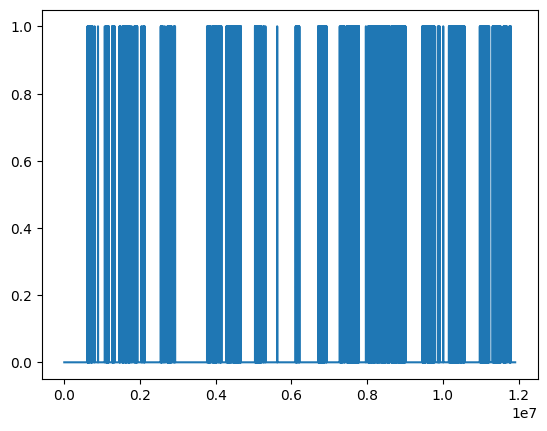

In [ ]:
plt.plot(valLabels)

In [ ]:
def labelingProcess(labelVector,maxTimeClose,minDuration,samplerate,verbose=0):
    aux=ndi.label(labelVector)
    preCandidates=ndi.find_objects(aux[0])
    if len(preCandidates)>0:    #consider the case of no precandidates at all
        if verbose>0:
            print("Number of raw candidates: "+str(len(preCandidates)))
        #1. Join candidates separated by less than the threshold
        kernelLength=int(maxTimeClose*samplerate)
        if kernelLength>0:
            kernel=np.ones((kernelLength,))
            labelVector=ndi.binary_closing(labelVector,kernel)
        #2. Discard candidates under minimum duration
        aux=ndi.label(labelVector)
        candidates=ndi.find_objects(aux[0])
        labelVector=np.zeros_like(labelVector)
        if len(candidates)>0:
            durations=np.apply_along_axis(lambda x: (x[0].stop-x[0].start)/samplerate,1,candidates)
            detections=[candidates[i] for i in np.where(durations>minDuration)[0]]
            for detection in detections:
                labelVector[detection]=1
            if verbose>0:
                print("Number of detections: "+str(len(detections)))
    return labelVector

In [ ]:
valProcessed=labelingProcess(valPredictions,0.3,0.3,200,verbose=1)

Number of raw candidates: 10382
Number of detections: 1126


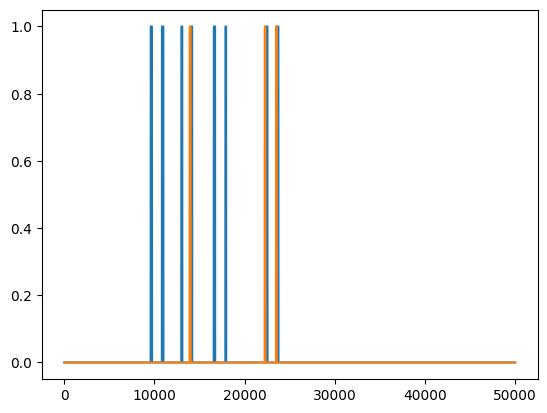

In [ ]:
plt.plot(valLabels[int(4*10**6):int(4.05*10**6)])
plt.plot(valProcessed[int(4*10**6):int(4.05*10**6)])

In [ ]:
F1(valLabels,valPredictions)

0.04527927017081859

In [ ]:
4/0

ZeroDivisionError: division by zero

In [ ]:
dataSplits["model"]=models
dataSplits["treeLimit"]=treeLimits
dataSplits["valF1"]=valF1s

In [ ]:
dataSplits

,train,val,test,model,treeLimit,valF1
0,"[0002, 0003, 0004, 0005, 0006, 0007, 0008, 000...","[0016, 0011]",0001,"XGBClassifier(base_score=0.5, booster='gbtree'...",50,0.293375
1,"[0004, 0005, 0006, 0007, 0008, 0009, 0010, 001...","[0003, 0001]",0002,"XGBClassifier(base_score=0.5, booster='gbtree'...",31,0.434505
2,"[0001, 0002, 0004, 0005, 0007, 0008, 0009, 001...","[0018, 0006]",0003,"XGBClassifier(base_score=0.5, booster='gbtree'...",38,0.127281
3,"[0002, 0003, 0005, 0006, 0007, 0008, 0010, 001...","[0009, 0001]",0004,"XGBClassifier(base_score=0.5, booster='gbtree'...",31,0.365497
4,"[0001, 0002, 0003, 0004, 0006, 0007, 0008, 000...","[0011, 0012]",0005,"XGBClassifier(base_score=0.5, booster='gbtree'...",40,0.236585
5,"[0001, 0002, 0003, 0004, 0007, 0008, 0010, 001...","[0005, 0009]",0006,"XGBClassifier(base_score=0.5, booster='gbtree'...",51,0.135772
6,"[0001, 0002, 0003, 0004, 0005, 0006, 0008, 000...","[0019, 0015]",0007,"XGBClassifier(base_score=0.5, booster='gbtree'...",32,0.052743
7,"[0001, 0002, 0003, 0004, 0005, 0006, 0007, 001...","[0009, 0019]",0008,"XGBClassifier(base_score=0.5, booster='gbtree'...",43,0.128350
8,"[0001, 0002, 0003, 0004, 0005, 0007, 0008, 001...","[0017, 0006]",0009,"XGBClassifier(base_score=0.5, booster='gbtree'...",40,0.115160
9,"[0001, 0002, 0003, 0004, 0005, 0006, 0007, 000...","[0019, 0012]",0010,"XGBClassifier(base_score=0.5, booster='gbtree'...",33,0.106669


In [ ]:
dumpPickle("CV_temporal_monday.pkl",dataSplits)

In [ ]:
trainLabels.shape

(94251600,)

In [ ]:
valLabels.shape

(13097200,)

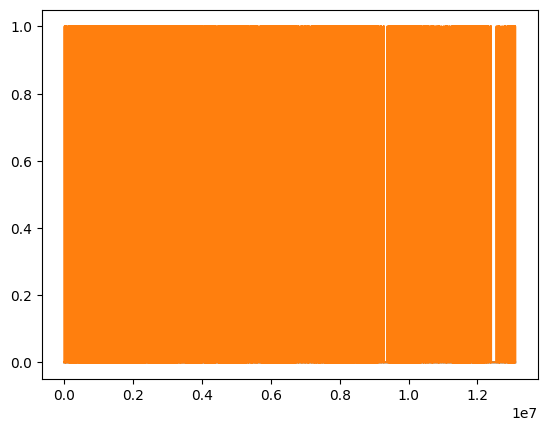

In [ ]:
plt.plot(valLabels)
plt.plot(valPredictions)

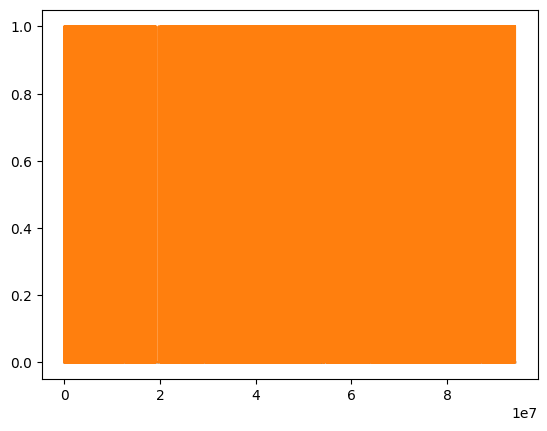

In [ ]:
plt.plot(trainLabels)
plt.plot(xgb_model.predict(trainFeatures))


In [ ]:
valFeatures.shape

(13097200, 5)

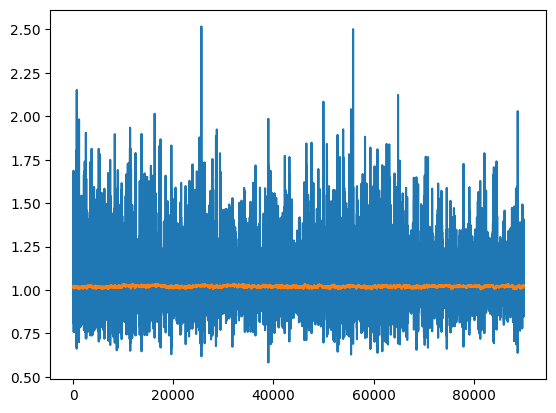

In [ ]:

plt.plot(valFeatures[10000:100000,4])
plt.plot(valFeatures[10000:100000,1])
